In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 5000)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.4f}'.format)


In [ ]:
 
# Cargar el archivo
#df = pd.read_csv('predicciones_finales.csv')
df_full = pd.read_parquet('./data/l_vm_completa_train.parquet', engine='fastparquet')
# Filtrar por los productos seleccionados solo las columnas PERIODO y TN
df_filtered = df_full[['PRODUCT_ID','PERIODO','ORDINAL', 'TN']]
# Agrupar por 'PRODUCT_ID','PERIODO','ORDINAL' sumando 'TN'
df_filtered = df_filtered.groupby(['PRODUCT_ID', 'PERIODO', 'ORDINAL'], as_index=False).sum()

# Calcular media y mediana histórica para cada PRODUCT_ID
media_tn = df_filtered.groupby('PRODUCT_ID')['TN'].mean().rename('mean_tn_historica')
mediana_tn = df_filtered.groupby('PRODUCT_ID')['TN'].median().rename('median_tn_historica')

# Unir ambas columnas por PRODUCT_ID a df_filtered
df_filtered = df_filtered.merge(media_tn, on='PRODUCT_ID', how='left')
df_filtered = df_filtered.merge(mediana_tn, on='PRODUCT_ID', how='left')

print(df_filtered.head())



   PRODUCT_ID  PERIODO  ORDINAL        TN  mean_tn_historica  median_tn_historica
0       20001   201701        1  934.7722          1398.3443            1418.0234
1       20001   201702        2  798.0162          1398.3443            1418.0234
2       20001   201703        3 1303.3577          1398.3443            1418.0234
3       20001   201704        4 1069.9613          1398.3443            1418.0234
4       20001   201705        5 1502.2013          1398.3443            1418.0234


In [4]:
df_filtered.to_csv('productos_agrupados.csv', index=False)
df_filtered = pd.read_csv('productos_agrupados.csv')

In [7]:
df = pd.read_csv('predicciones_finales.csv')

In [8]:
# solo imprimir las columna PRODUCT_ID y las que contengan mean, median o std
columnas_a_imprimir = ['PRODUCT_ID'] + [col for col in df.columns if 'mean' in col or 'median' in col or 'std' in col]
df_res = df[columnas_a_imprimir]
print(df_res.head(20))

    PRODUCT_ID  mlp_median  lgbm_median  ensemble_median  mlp_mean  lgbm_mean  ensemble_mean   mlp_std  lgbm_std  ensemble_std
0        20001   2618.6396     918.6569        1084.8481 3084.7244   963.1231      2023.9242 2627.0340  115.3843     2135.1941
1        20002    947.1138     939.8261         939.8261 1128.2811   947.6566      1037.9689  648.0220   60.7561      466.8095
2        20003    756.6586     704.0600         706.4827  802.9189   704.8206       753.8697  388.0083   33.9816      278.4179
3        20004    362.2552     509.6626         486.8227  364.5149   506.1119       435.3135  140.8418   23.7860      123.1304
4        20005    465.1850     549.5322         539.5082  488.5388   549.7769       519.1579  218.3652   22.4186      157.4694
5        20006    321.1096     404.0621         393.7012  324.5753   402.4708       363.5230   95.1245   15.1565       78.2597
6        20007    318.0902     384.1450         376.8549  326.2437   384.1812       355.2125   85.8302   15.506

In [9]:
df_res.to_csv('predicciones_finales_resumen.csv', index=False)
df = pd.read_csv('predicciones_finales_resumen.csv')

In [11]:
# Agregar las columnas de media y mediana historica a df por PRODUCT_ID
df = df.merge(media_tn, on='PRODUCT_ID', how='left')
df = df.merge(mediana_tn, on='PRODUCT_ID', how='left')   


Top 50 PRODUCT_ID más interesantes para analizar ventas históricas:
[20001, 20004, 20005, 20003, 20009, 20006, 20013, 20007, 20032, 20127, 20010, 20011, 20014, 20018, 20012, 20020, 20017, 20089, 20021, 20015, 20085, 20035, 20002, 20049, 20037, 20143, 20031, 20210, 20019, 20008, 20044, 20024, 20027, 20084, 20174, 20022, 20030, 20236, 20080, 20038, 20150, 20029, 20095, 20116, 20100, 20026, 20047, 20051, 20135, 20065]

Tabla resumen:
    PRODUCT_ID  mlp_median  lgbm_median  ensemble_median  mlp_mean  lgbm_mean  ensemble_mean   mlp_std  lgbm_std  ensemble_std  mean_tn_historica  median_tn_historica  abs_diff_mlp_lgbm_median
0        20001   2618.6396     918.6569        1084.8481 3084.7244   963.1231      2023.9242 2627.0340  115.3843     2135.1941          1398.3443            1418.0234                 1699.9827
1        20004    362.2552     509.6626         486.8227  364.5149   506.1119       435.3135  140.8418   23.7860      123.1304           671.6154             596.9093            

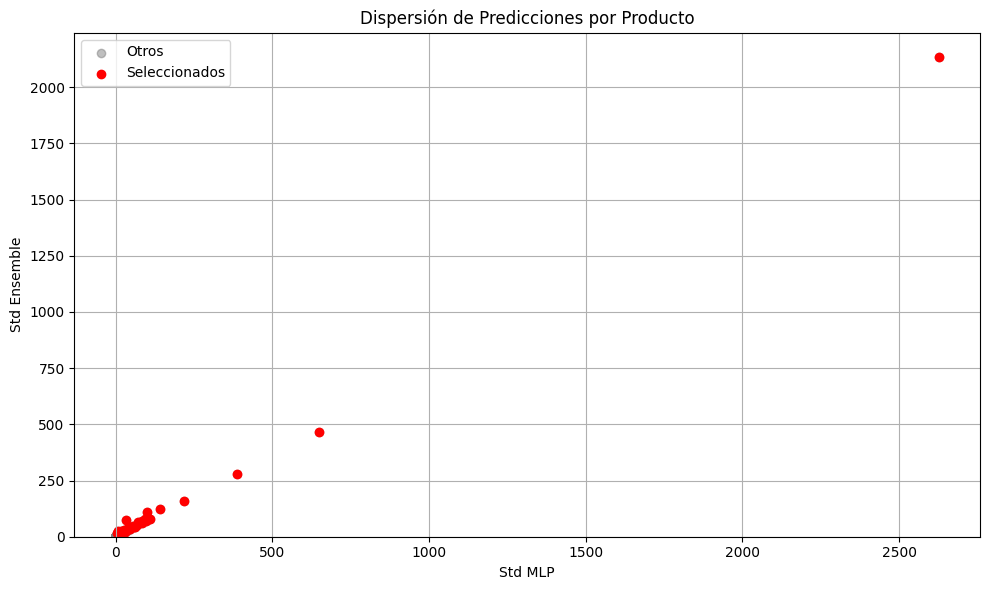


IDs exportados a productos_a_analizar.csv


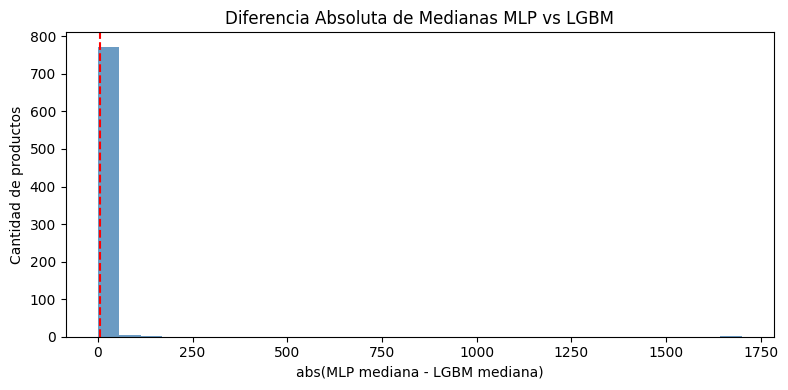

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Detectar productos con mayor dispersión de predicción ---
top_n = 50  # Solo los primeros 20
df['abs_diff_mlp_lgbm_median'] = (df['mlp_median'] - df['lgbm_median']).abs()

df_rank = df.copy()
df_rank['mlp_std_rank'] = df['mlp_std'].rank(ascending=False, method='min')
df_rank['ensemble_std_rank'] = df['ensemble_std'].rank(ascending=False, method='min')
df_rank['abs_diff_median_rank'] = df['abs_diff_mlp_lgbm_median'].rank(ascending=False, method='min')
df_rank['total_score'] = df_rank[['mlp_std_rank', 'ensemble_std_rank', 'abs_diff_median_rank']].mean(axis=1)
df_rank = df_rank.sort_values('total_score').reset_index(drop=True)

# Top productos
top_products = df_rank.head(top_n)['PRODUCT_ID'].tolist()

print(f"\nTop {top_n} PRODUCT_ID más interesantes para analizar ventas históricas:")
print(top_products)

# --- 2. Tabla resumen de esos productos ---
cols = [
    'PRODUCT_ID', 
    'mlp_median', 'lgbm_median', 'ensemble_median',
    'mlp_mean', 'lgbm_mean', 'ensemble_mean',
    'mlp_std', 'lgbm_std', 'ensemble_std',
    'mean_tn_historica', 'median_tn_historica',
    'abs_diff_mlp_lgbm_median'
]

print("\nTabla resumen:")
print(df_rank[cols].head(top_n))

# --- 3. Gráfico de dispersión ---
plt.figure(figsize=(10, 6))
plt.scatter(df['mlp_std'], df['ensemble_std'], alpha=0.5, c='gray', label='Otros')
plt.scatter(
    df.loc[df['PRODUCT_ID'].isin(top_products), 'mlp_std'],
    df.loc[df['PRODUCT_ID'].isin(top_products), 'ensemble_std'],
    color='red', label='Seleccionados'
)
plt.xlabel('Std MLP')
plt.ylabel('Std Ensemble')
plt.title('Dispersión de Predicciones por Producto')
plt.ylim(bottom=0)  # Eje Y desde cero
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- 4. Guardar los IDs para análisis histórico posterior ---
pd.Series(top_products, name='PRODUCT_ID').to_csv('productos_a_analizar.csv', index=False)
print("\nIDs exportados a productos_a_analizar.csv")

# --- 5. Histograma diferencia de medianas ---
plt.figure(figsize=(8, 4))
plt.hist(df['abs_diff_mlp_lgbm_median'], bins=30, color='steelblue', alpha=0.8)
plt.axvline(df.loc[df['PRODUCT_ID'].isin(top_products), 'abs_diff_mlp_lgbm_median'].min(), color='red', linestyle='--')
plt.title('Diferencia Absoluta de Medianas MLP vs LGBM')
plt.xlabel('abs(MLP mediana - LGBM mediana)')
plt.ylabel('Cantidad de productos')
plt.ylim(bottom=0)  # Eje Y desde cero
plt.tight_layout()
plt.show()



In [13]:
import pandas as pd
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.lib.units import mm
from reportlab.lib import colors

# Tu DataFrame 'df_rank' debe tener todas las columnas necesarias.

pdf_filename = "informe_productos.pdf"
c = canvas.Canvas(pdf_filename, pagesize=A4)
width, height = A4

def write_line(text, y, size=10, color=colors.black, bold=False):
    font = "Helvetica-Bold" if bold else "Helvetica"
    c.setFont(font, size)
    c.setFillColor(color)
    c.drawString(20*mm, y, text)

y = height - 20*mm

# --- ENCABEZADO CON CRITERIO DE ORDEN ---
write_line("INFORME DE PREDICCIONES POR PRODUCTO", y, size=15, color=colors.darkblue, bold=True)
y -= 12*mm
write_line("Criterio de orden:", y, size=11, bold=True)
y -= 6*mm
write_line(
    "Los productos están ordenados de mayor a menor score según la media del ranking de:",
    y, size=10
)
y -= 5*mm
write_line(
    "- Desvío estándar de predicciones MLP",
    y, size=10
)
y -= 4*mm
write_line(
    "- Desvío estándar de predicciones Ensemble",
    y, size=10
)
y -= 4*mm
write_line(
    "- Diferencia absoluta entre la mediana de MLP y LGBM",
    y, size=10
)
y -= 4*mm
write_line(
    "(Un ranking más alto indica productos con mayor dispersión o discordancia entre modelos.)",
    y, size=9, color=colors.gray
)
y -= 10*mm

for idx, row in df_rank.iterrows():
    if y < 40*mm:
        c.showPage()
        y = height - 20*mm

    pid = int(row['PRODUCT_ID'])
    median_hist = row.get('median_tn_historica', float('nan'))
    median_ensemble = row.get('ensemble_median', float('nan'))
    mean_hist = row.get('mean_tn_historica', float('nan'))
    mean_ensemble = row.get('ensemble_mean', float('nan'))
    std_ensemble = row.get('ensemble_std', float('nan'))

    gap_median = median_ensemble - median_hist
    gap_mean = mean_ensemble - mean_hist

    perc_gap_median = 100 * gap_median / (median_hist + 1e-8) if pd.notnull(median_hist) else float('nan')
    perc_gap_mean = 100 * gap_mean / (mean_hist + 1e-8) if pd.notnull(mean_hist) else float('nan')

    if pd.isnull(median_hist) or pd.isnull(median_ensemble):
        comentario = "⏳ Sin histórico suficiente para comparar."
        color = colors.gray
    elif abs(perc_gap_median) > 30:
        comentario = "⚠️ GRAN diferencia en la mediana predicha vs histórica."
        color = colors.red
    elif abs(perc_gap_median) > 15:
        comentario = "🔶 Diferencia apreciable en la mediana predicha."
        color = colors.orange
    elif std_ensemble > 0.20 * mean_ensemble:
        comentario = "⚠️ Alta dispersión en el ensemble."
        color = colors.darkorange
    else:
        comentario = "✅ Predicción alineada a la historia."
        color = colors.green

    # Escribir datos del producto
    write_line(f"PRODUCT_ID {pid}:", y, size=11, color=colors.darkblue, bold=True); y -= 8*mm
    write_line(f"  - Mediana histórica TN: {median_hist:.2f}", y); y -= 5*mm
    write_line(f"  - Mediana ensemble:    {median_ensemble:.2f}  ({perc_gap_median:+.1f}%)", y); y -= 5*mm
    write_line(f"  - Media histórica TN:  {mean_hist:.2f}", y); y -= 5*mm
    write_line(f"  - Media ensemble:      {mean_ensemble:.2f}  ({perc_gap_mean:+.1f}%)", y); y -= 5*mm
    write_line(f"  - STD ensemble:        {std_ensemble:.2f}", y); y -= 5*mm
    write_line(f"  - {comentario}", y, color=color); y -= 8*mm

    y -= 4*mm  # Espacio entre productos

c.save()
print(f"\nInforme PDF generado como: {pdf_filename}")




Informe PDF generado como: informe_productos.pdf


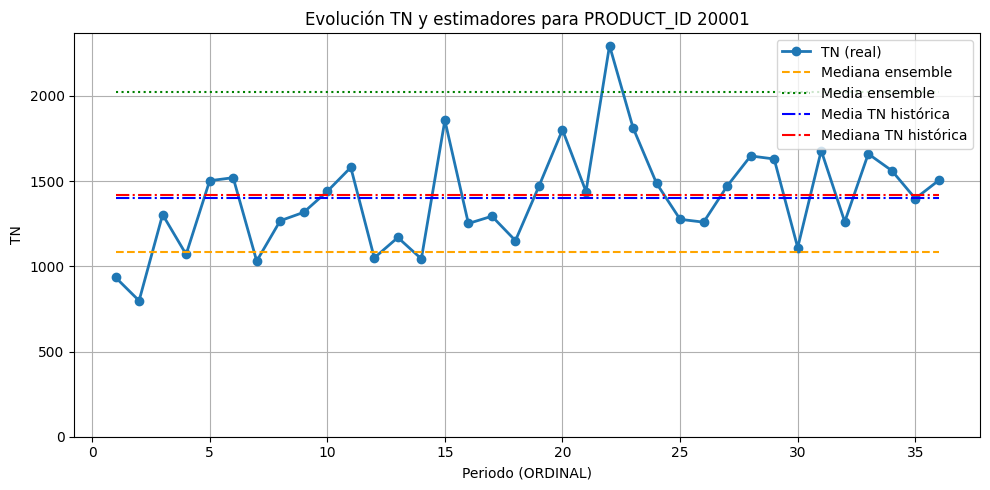

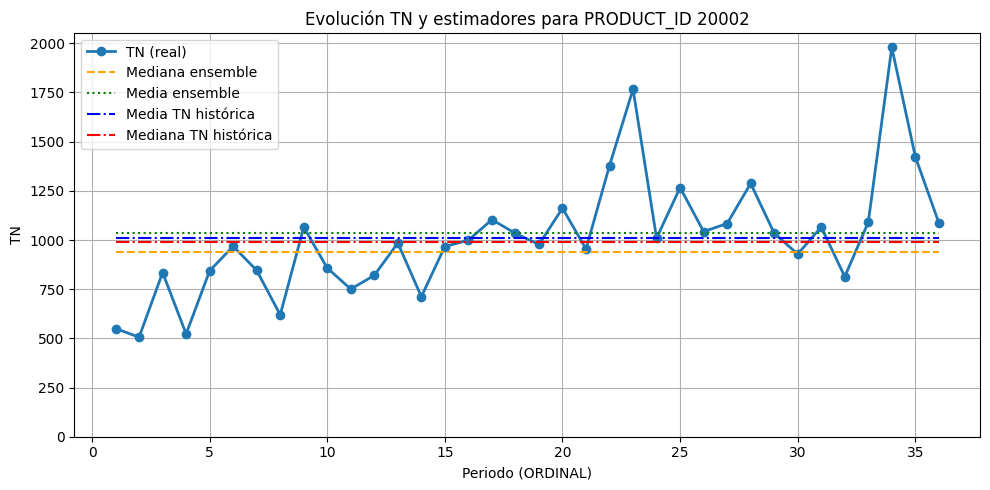

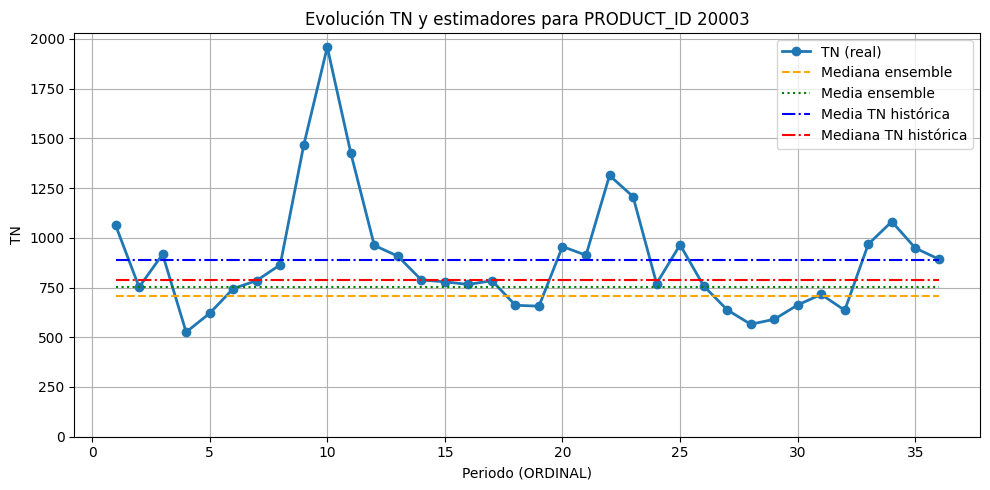

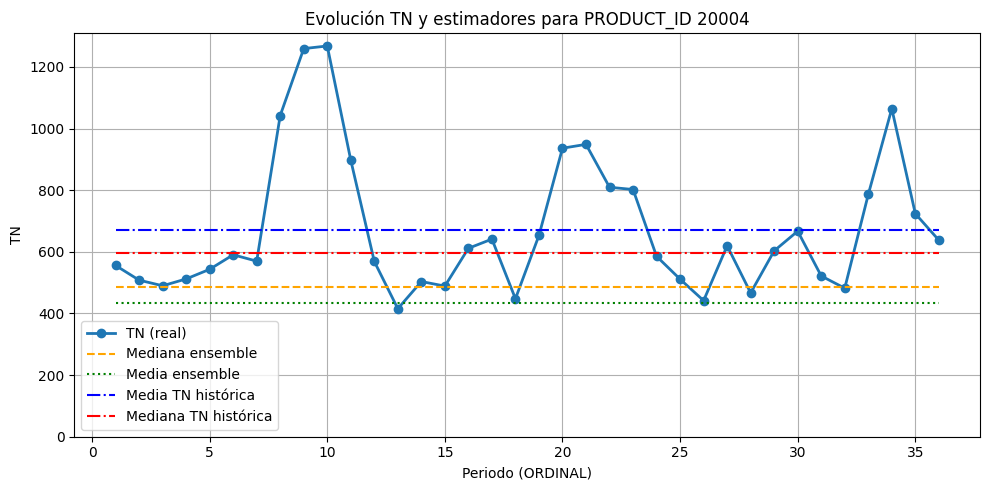

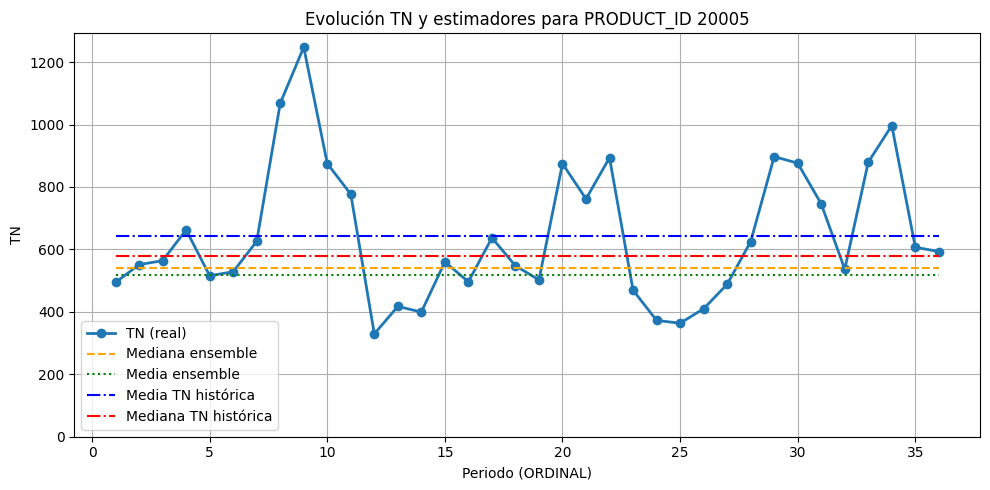

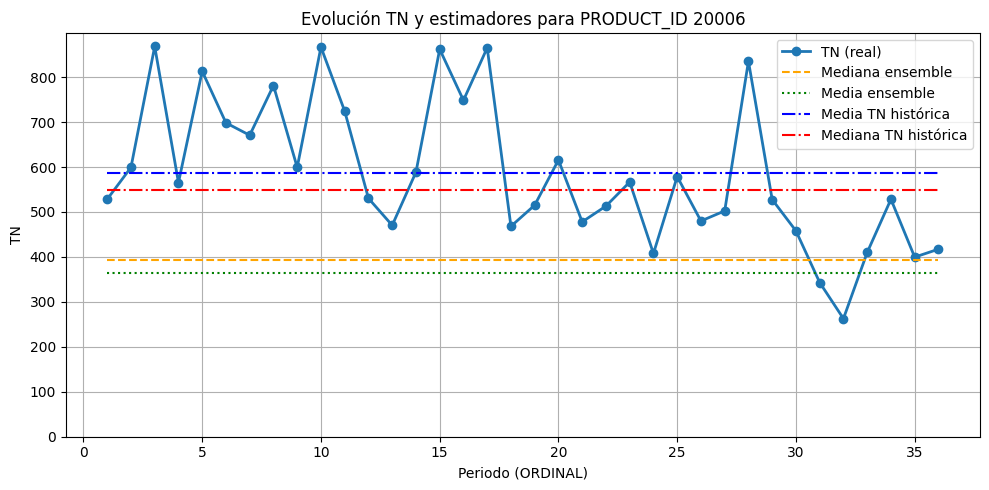

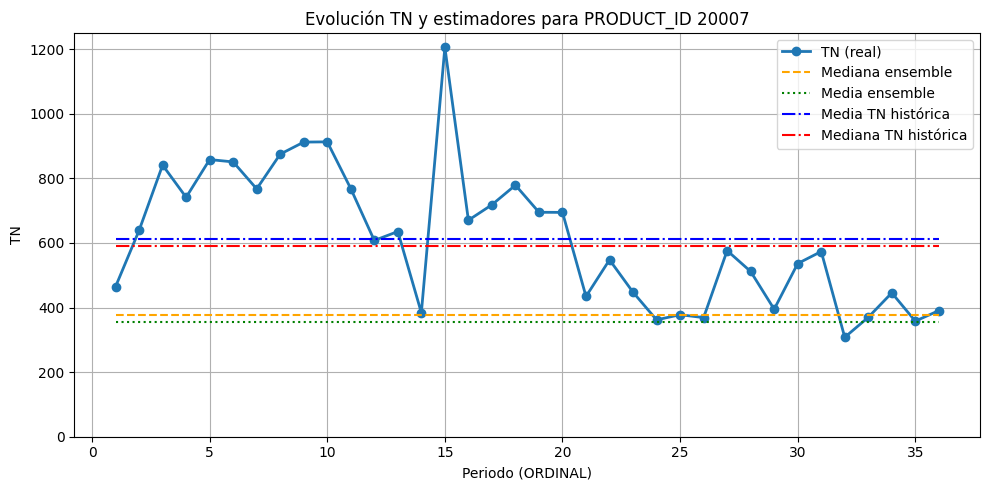

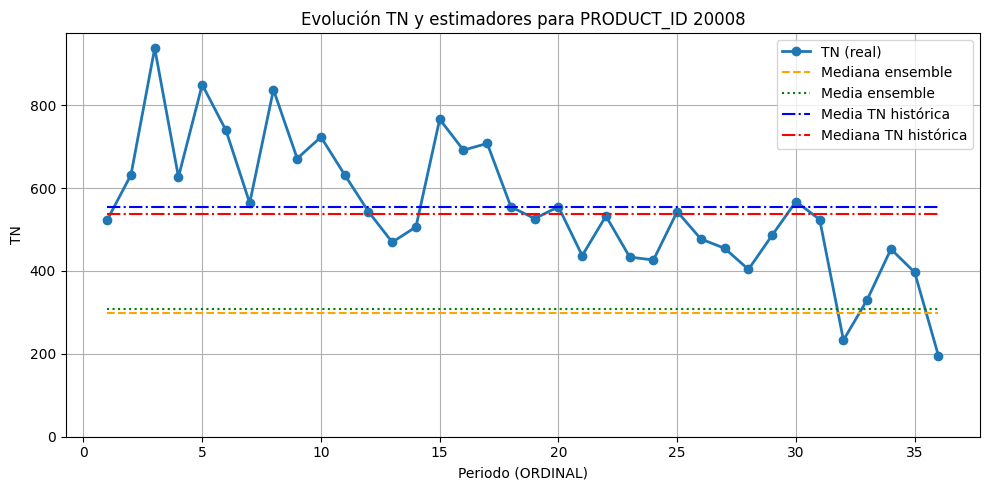

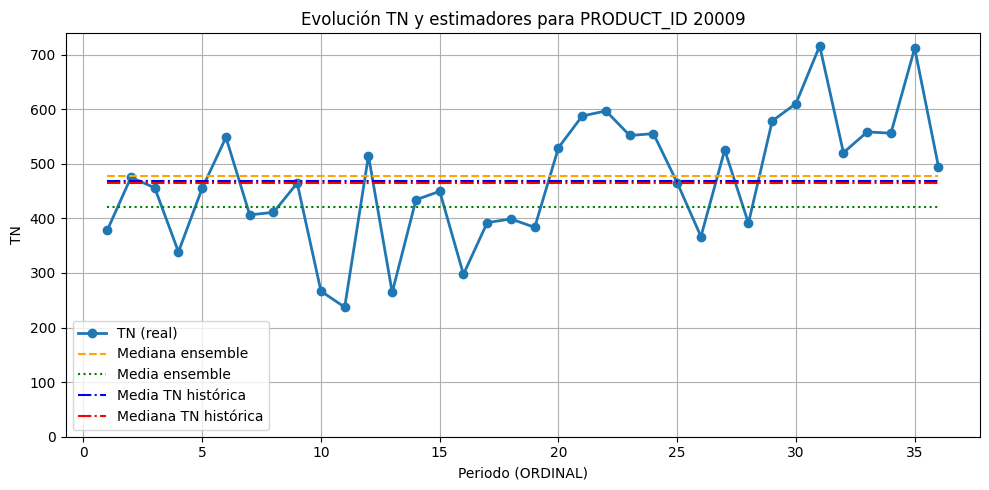

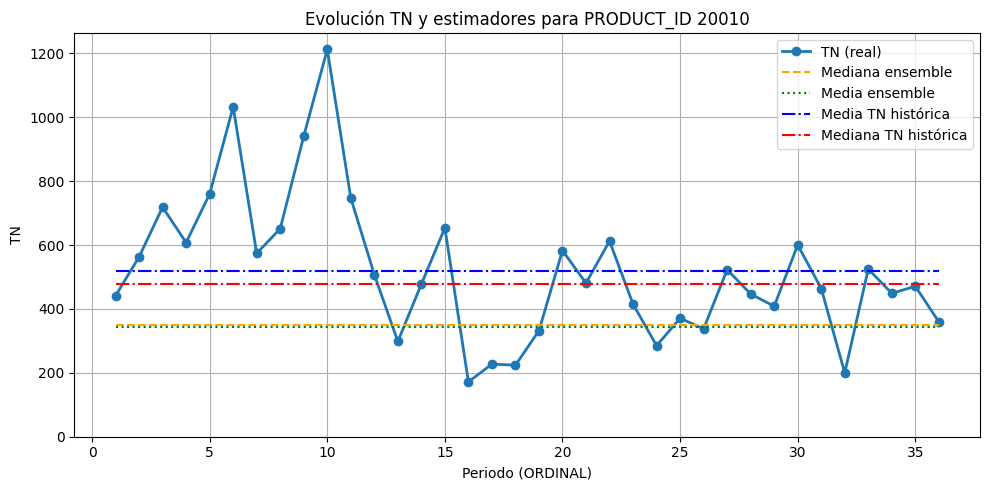

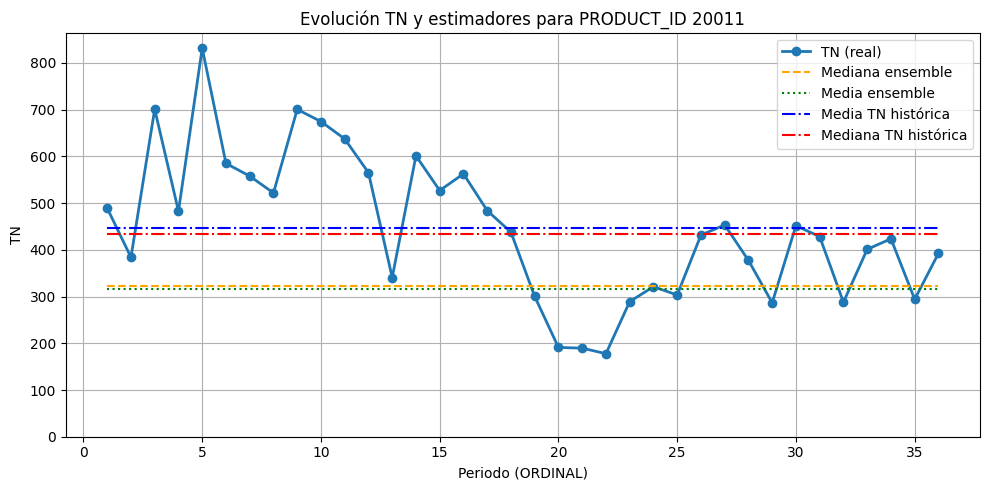

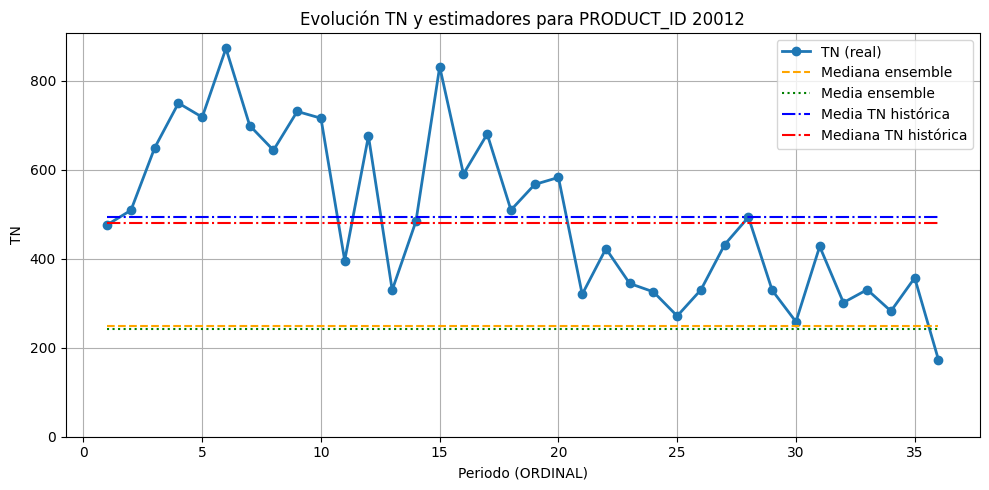

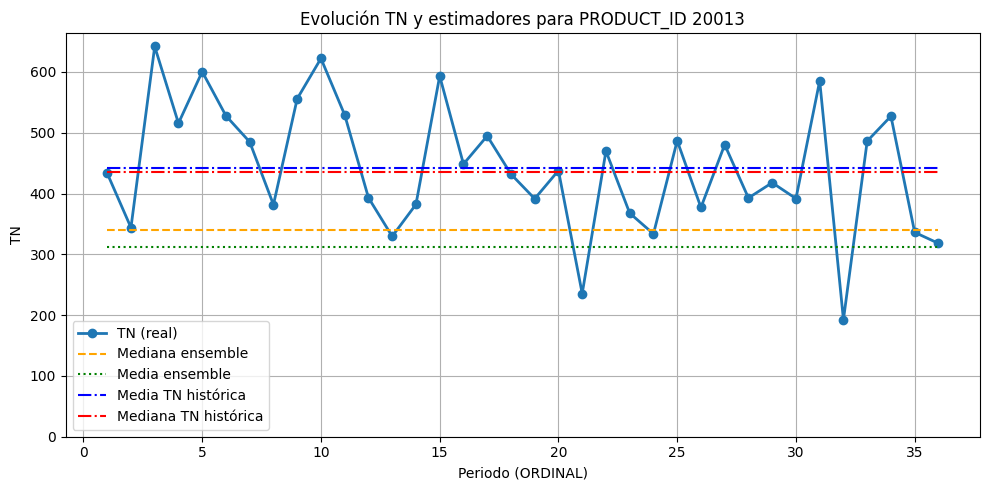

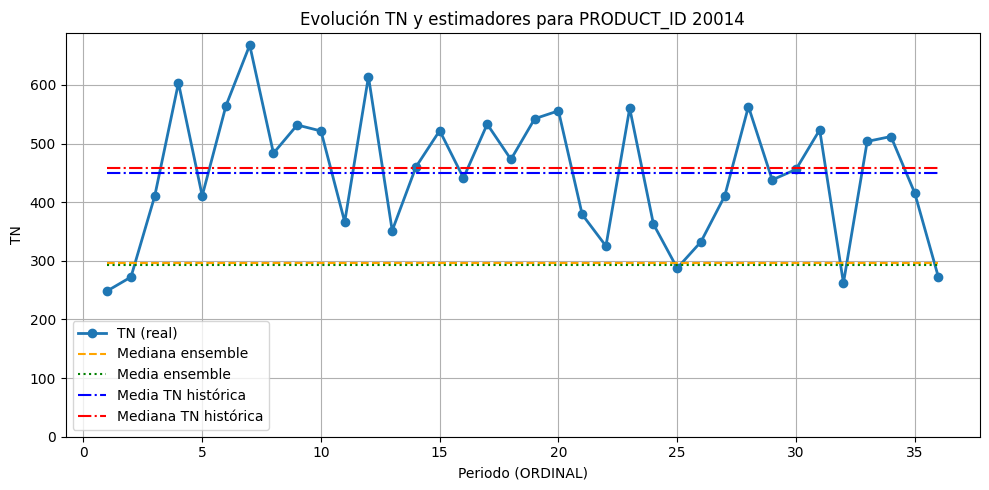

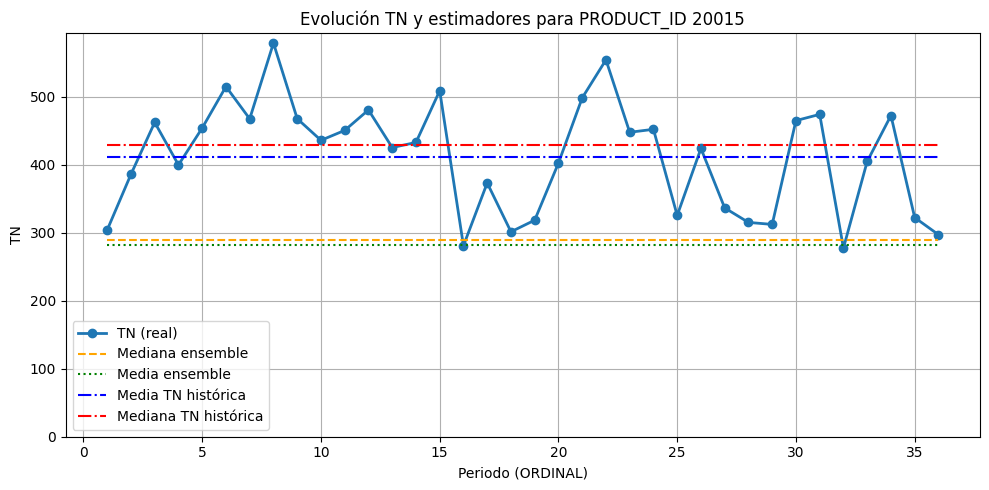

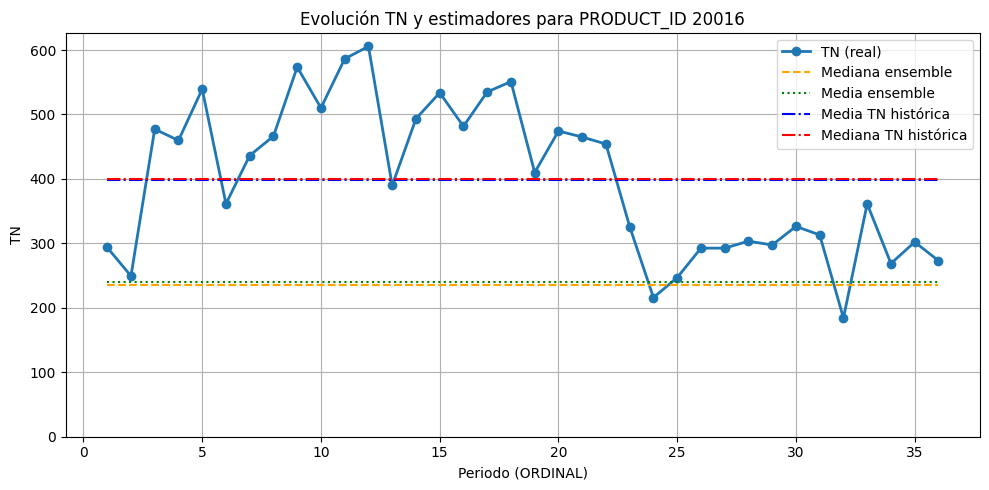

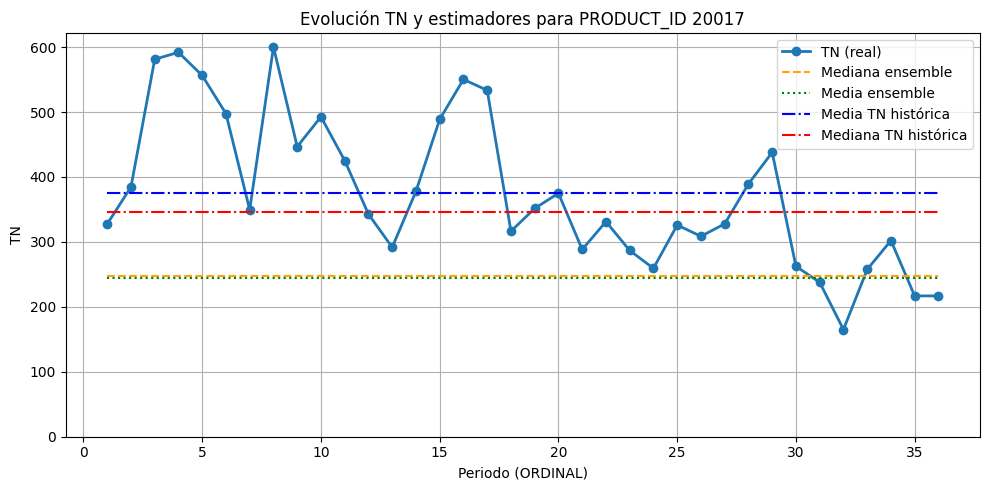

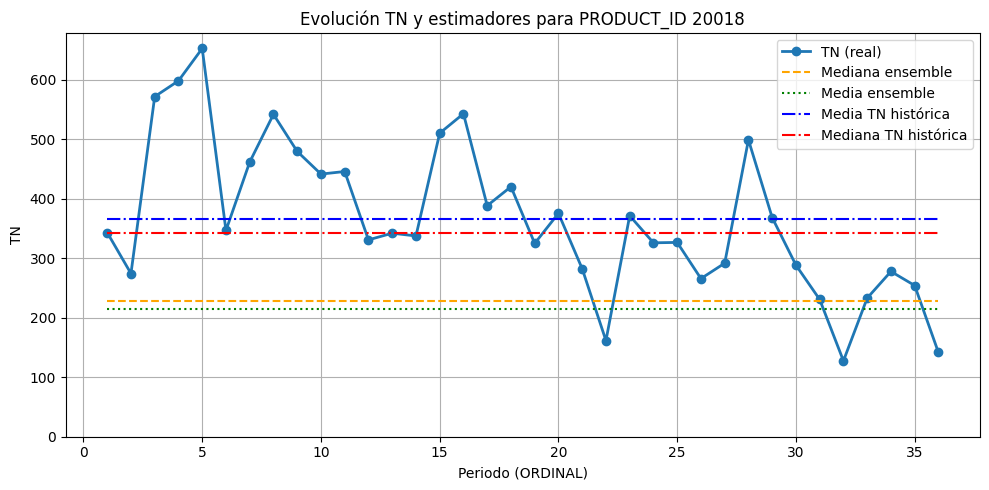

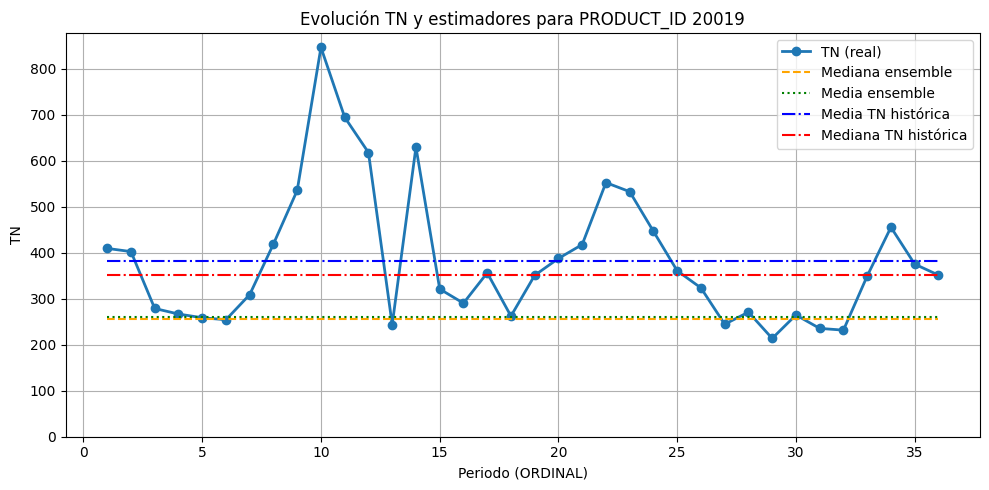

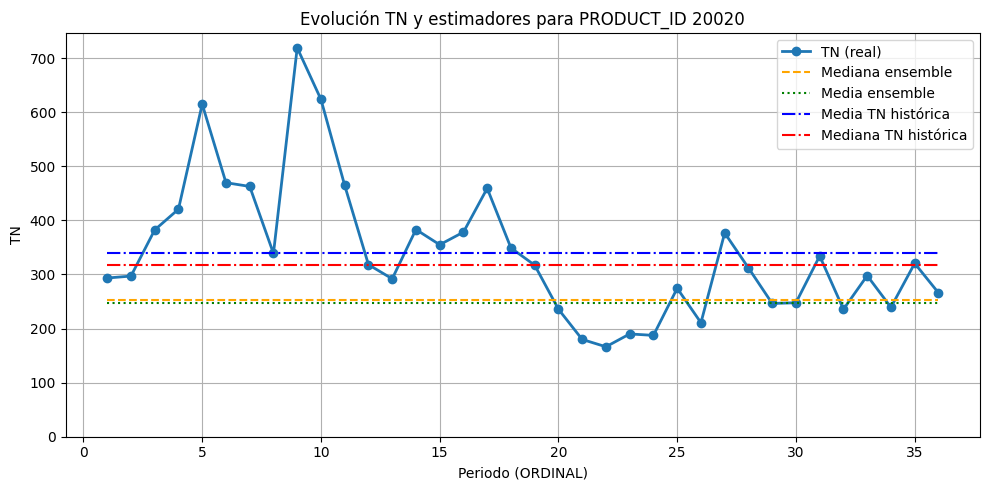

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Merge para incorporar medias/medianas del ensemble ---
df_merged = df_filtered.merge(
    df[['PRODUCT_ID', 'ensemble_median', 'ensemble_mean']],
    on='PRODUCT_ID',
    how='left'
)

# Seleccionar los primeros 20 PRODUCT_ID únicos
productos = df_merged['PRODUCT_ID'].unique()[:20]

for pid in productos:
    data = df_merged[df_merged['PRODUCT_ID'] == pid].sort_values('ORDINAL')
    
    # Media y mediana históricas de TN para ese producto
    media_hist = data['TN'].mean()
    mediana_hist = data['TN'].median()

    plt.figure(figsize=(10, 5))
    plt.plot(data['ORDINAL'], data['TN'], marker='o', label='TN (real)', linewidth=2)
    plt.hlines(data['ensemble_median'].iloc[0], data['ORDINAL'].min(), data['ORDINAL'].max(),
               colors='orange', linestyles='--', label='Mediana ensemble')
    plt.hlines(data['ensemble_mean'].iloc[0], data['ORDINAL'].min(), data['ORDINAL'].max(),
               colors='green', linestyles=':', label='Media ensemble')
    plt.hlines(media_hist, data['ORDINAL'].min(), data['ORDINAL'].max(),
               colors='blue', linestyles='-.', label='Media TN histórica')
    plt.hlines(mediana_hist, data['ORDINAL'].min(), data['ORDINAL'].max(),
               colors='red', linestyles='-.', label='Mediana TN histórica')
    plt.title(f'Evolución TN y estimadores para PRODUCT_ID {pid}')
    plt.xlabel('Periodo (ORDINAL)')
    plt.ylabel('TN')
    plt.ylim(bottom=0)  # Eje Y desde 0
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    # Para guardar en vez de mostrar:
    # plt.savefig(f"evolucion_tn_{pid}.png")
    # plt.close()



In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Merge para incorporar medias/medianas del ensemble ---
df_merged = df_filtered.merge(
    df[['PRODUCT_ID', 'ensemble_median', 'ensemble_mean']],
    on='PRODUCT_ID',
    how='left'
)

# Crear columna de fecha: último día del mes a partir del PERIODO
# df_merged['FECHA'] = (
#     pd.to_datetime(df_merged['PERIODO'].astype(str) + '01', format='%Y%m%d')
#     + pd.offsets.MonthEnd(0)
# )
df_merged['FECHA'] = pd.to_datetime(df_merged['PERIODO'].astype(str), format='%Y%m')

print(df_merged.head())

   PRODUCT_ID  PERIODO  ORDINAL        TN  mean_tn_historica  median_tn_historica  ensemble_median  ensemble_mean      FECHA
0       20001   201701        1  934.7722          1398.3443            1418.0234        1084.8481      2023.9242 2017-01-01
1       20001   201702        2  798.0162          1398.3443            1418.0234        1084.8481      2023.9242 2017-02-01
2       20001   201703        3 1303.3577          1398.3443            1418.0234        1084.8481      2023.9242 2017-03-01
3       20001   201704        4 1069.9613          1398.3443            1418.0234        1084.8481      2023.9242 2017-04-01
4       20001   201705        5 1502.2013          1398.3443            1418.0234        1084.8481      2023.9242 2017-05-01


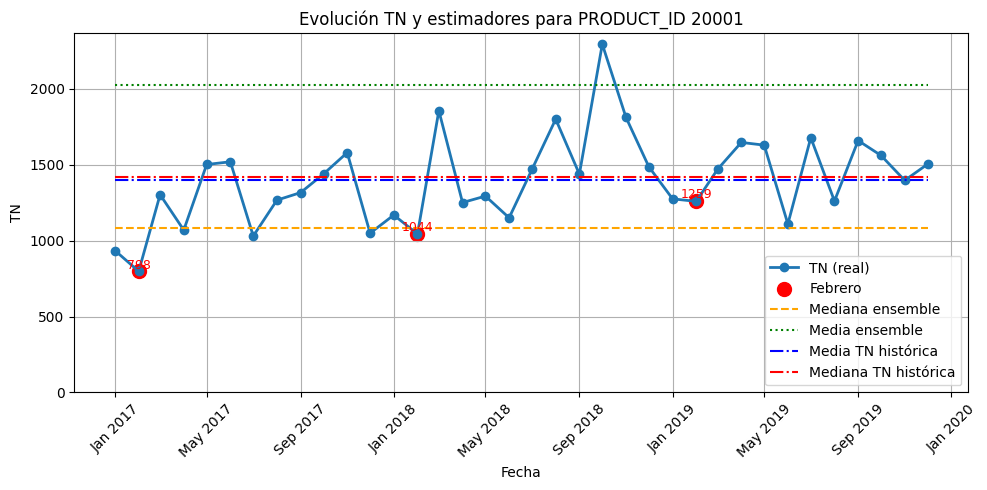

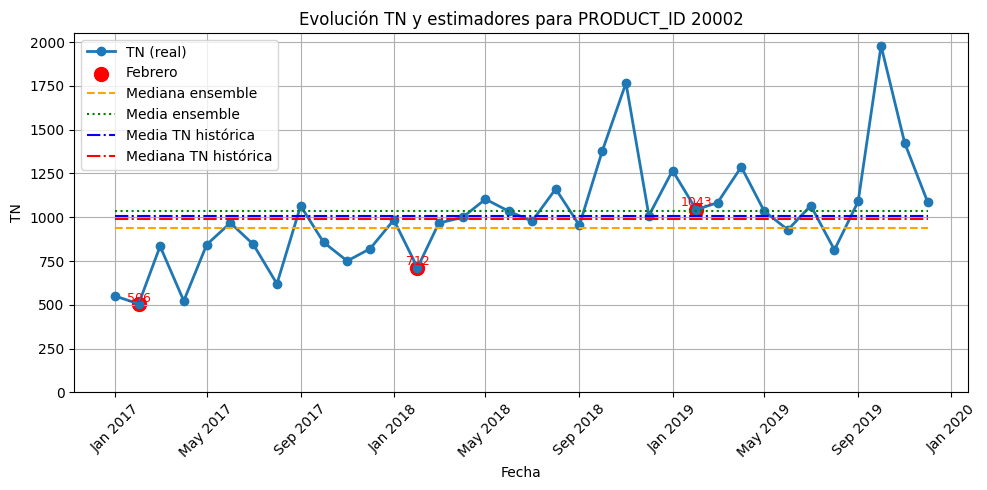

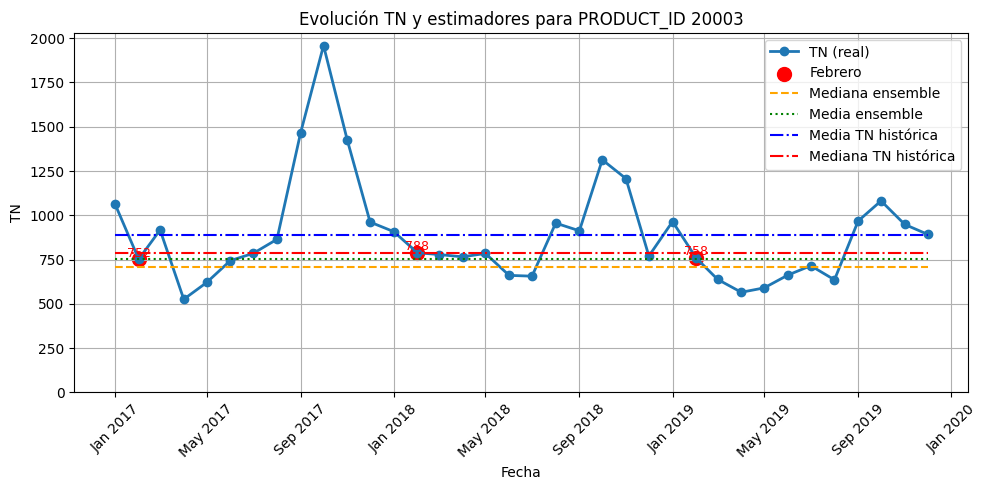

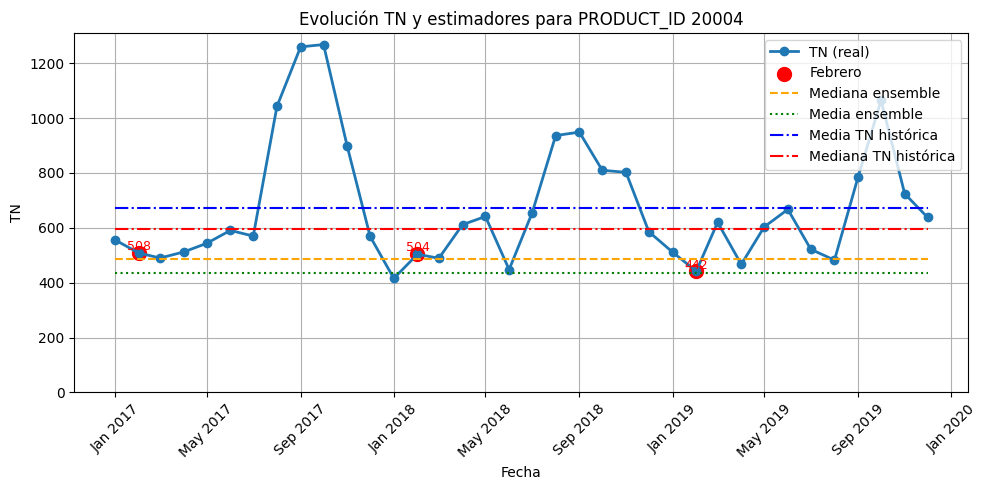

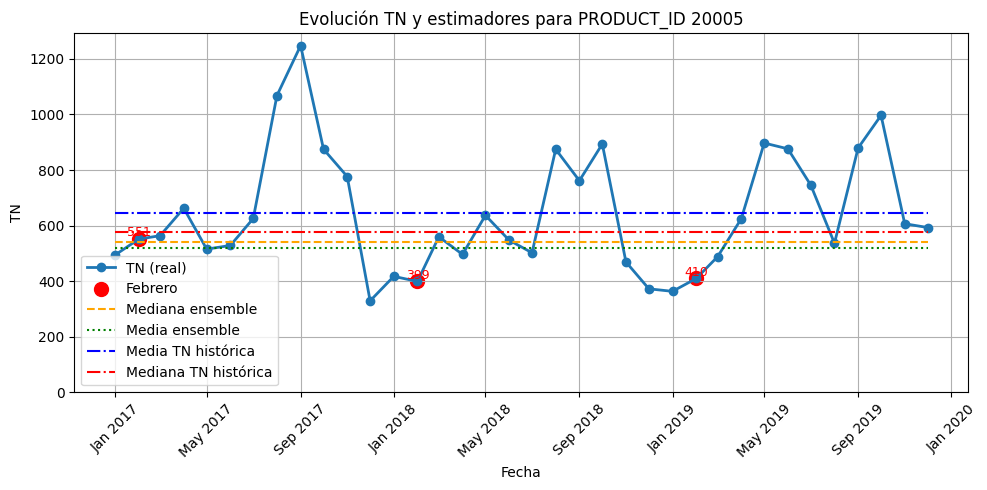

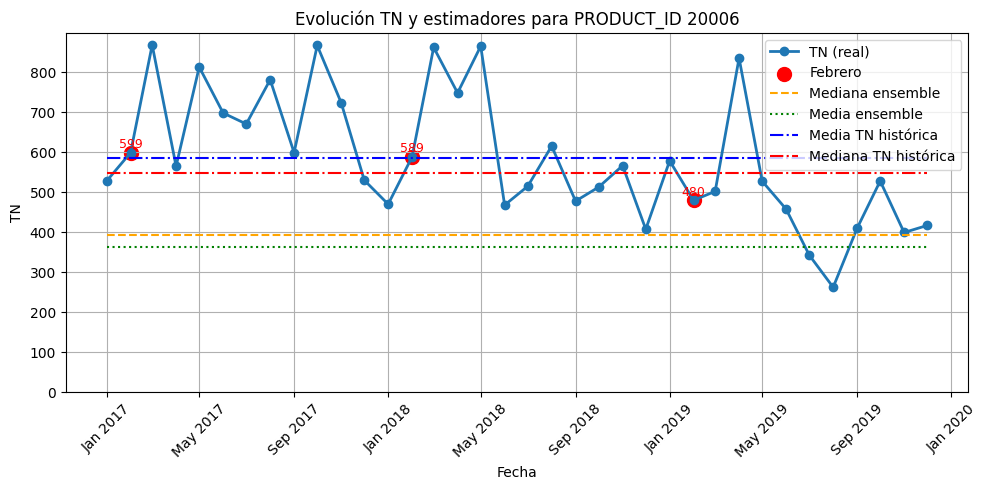

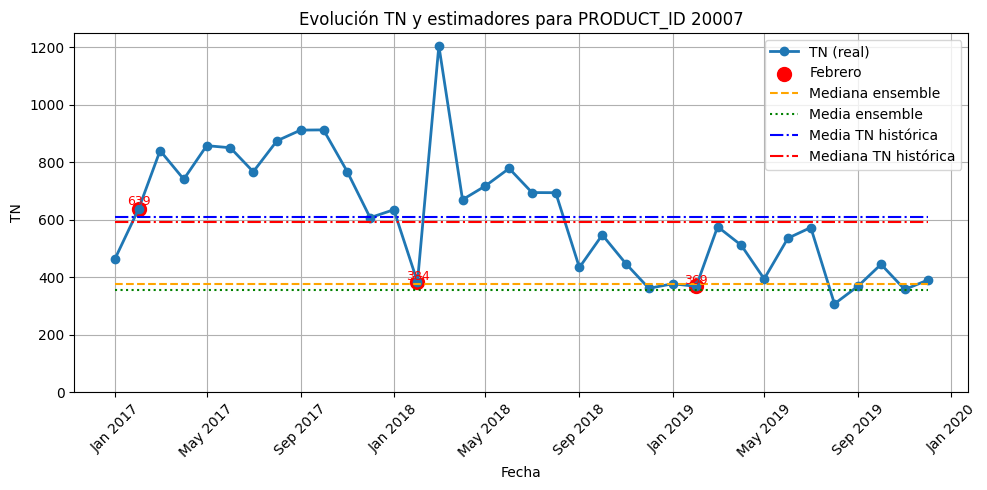

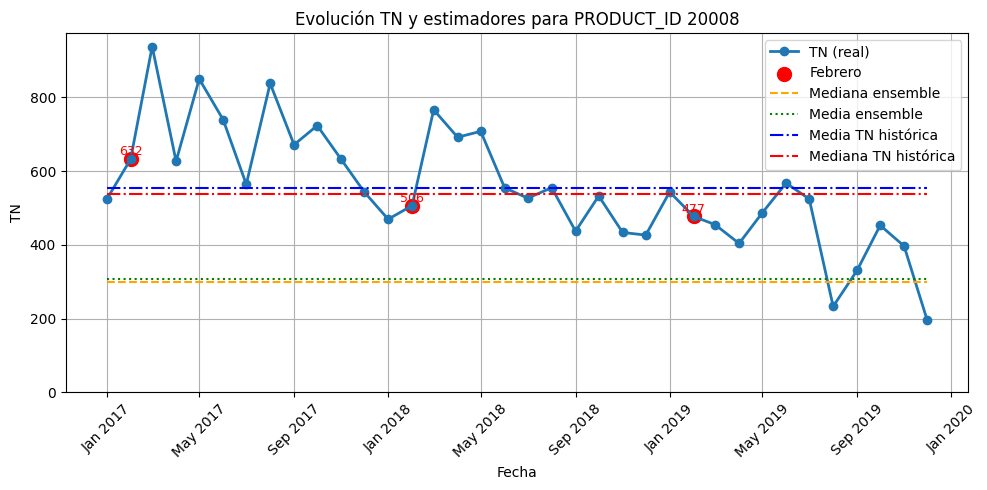

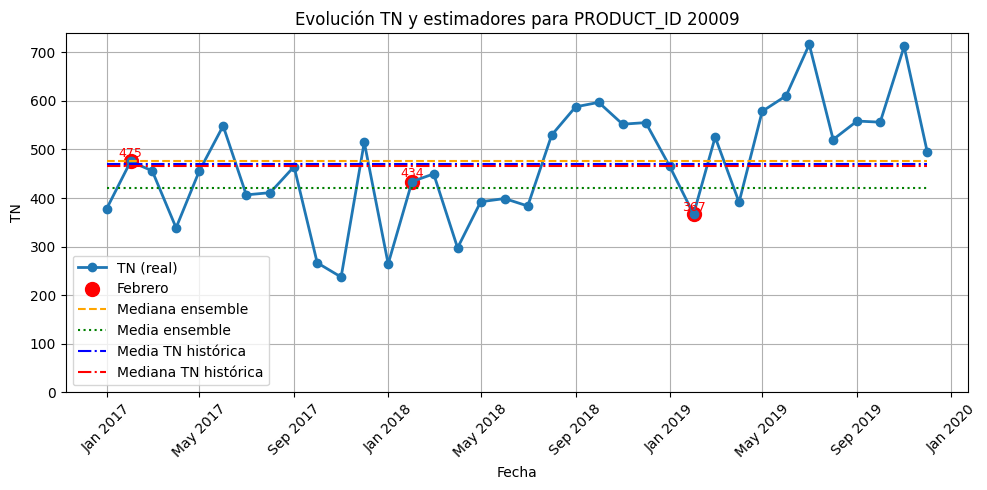

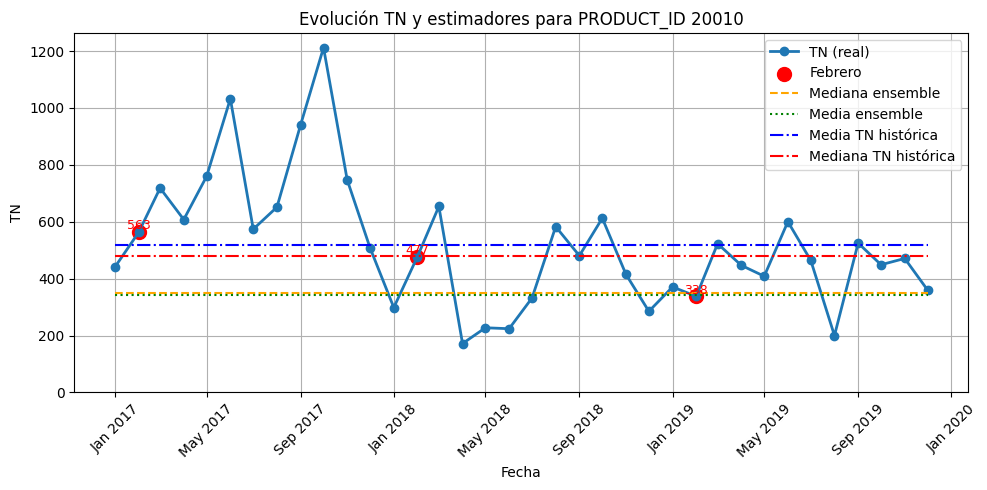

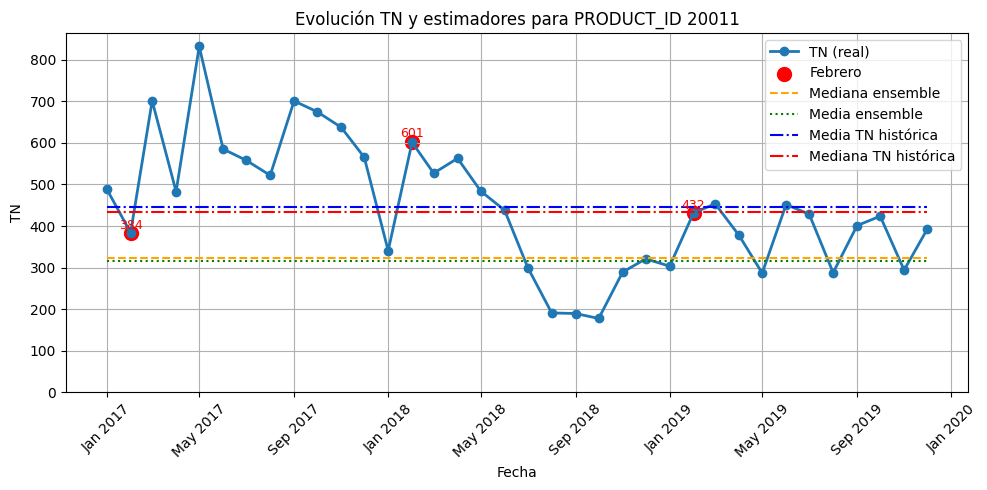

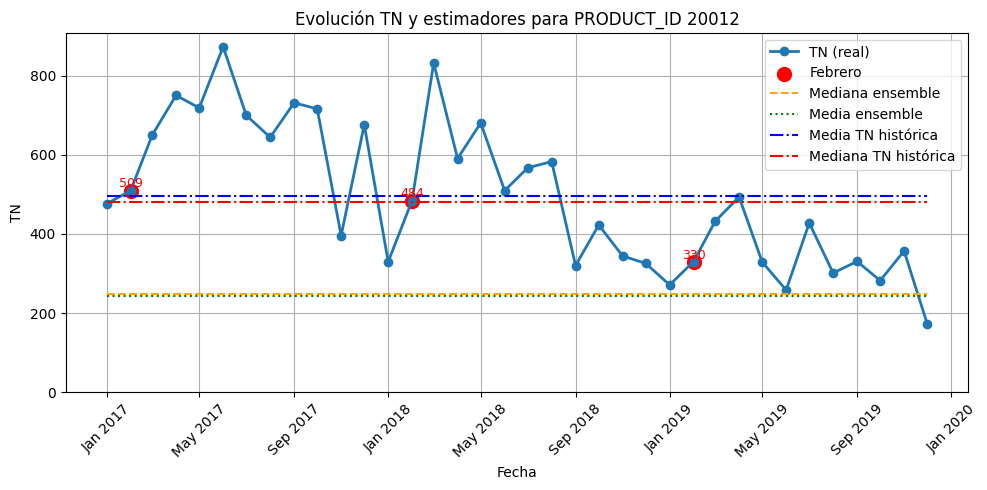

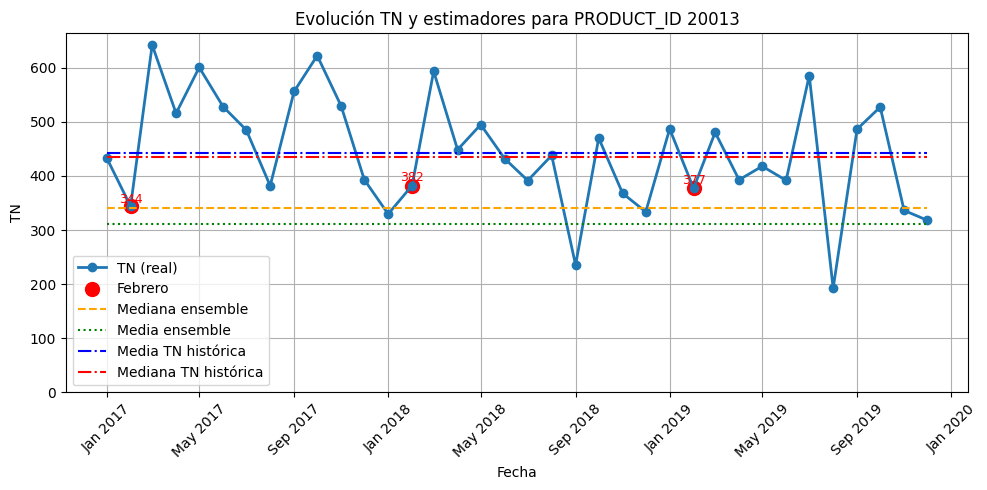

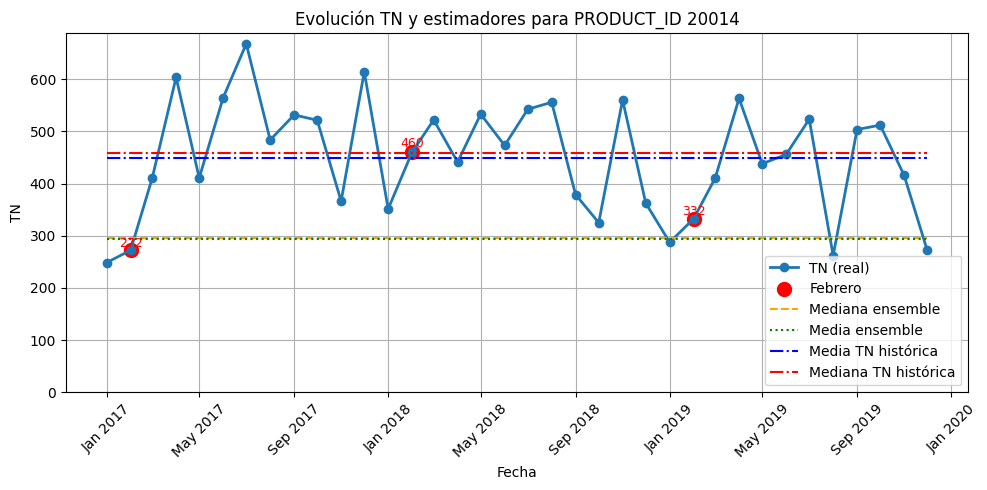

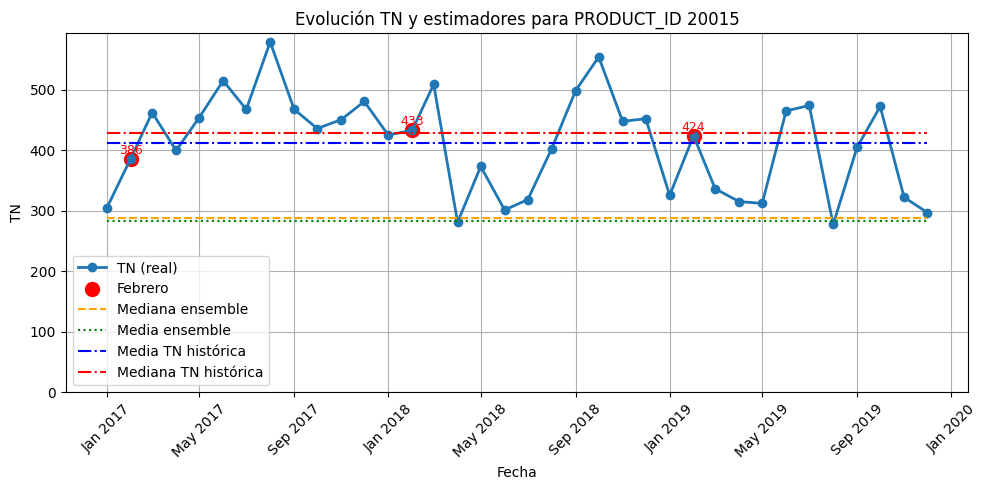

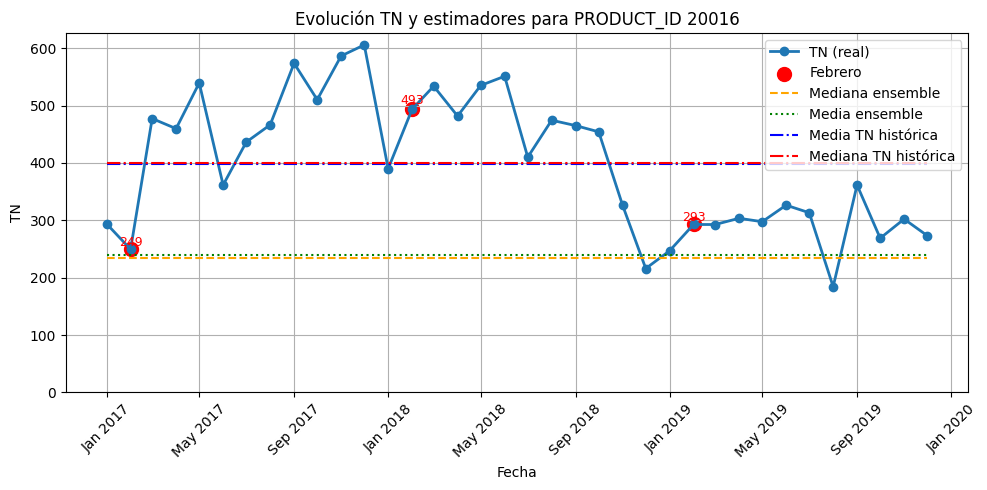

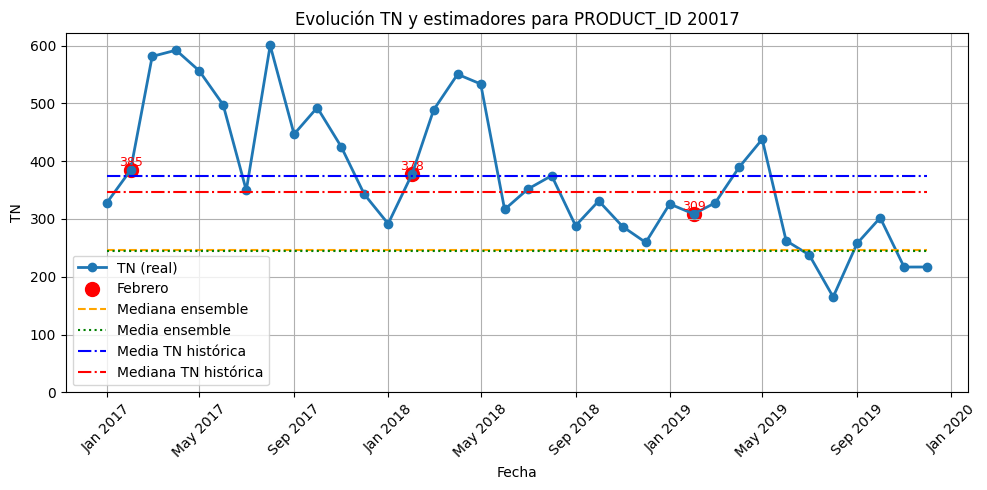

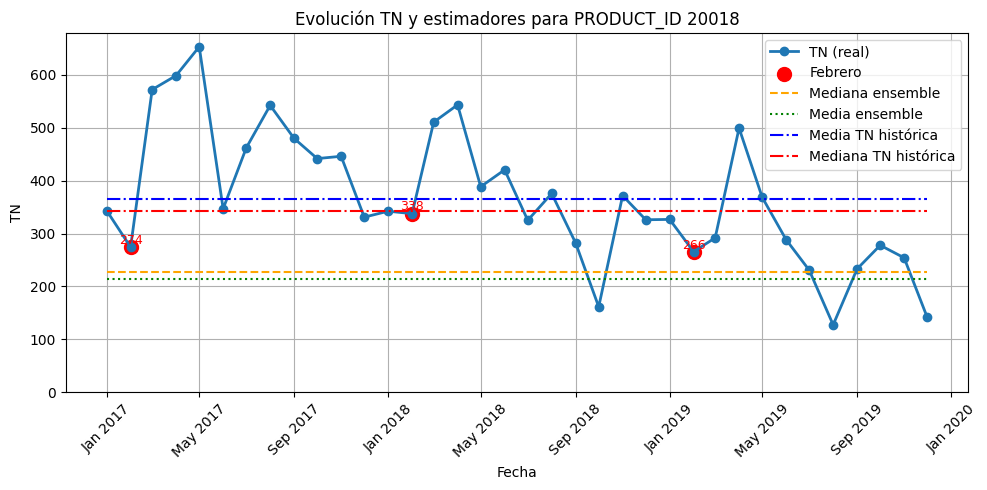

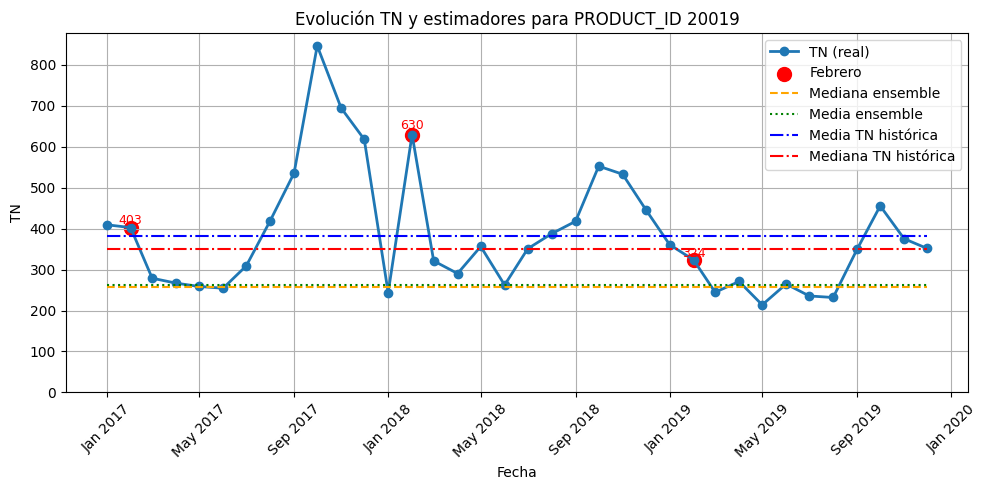

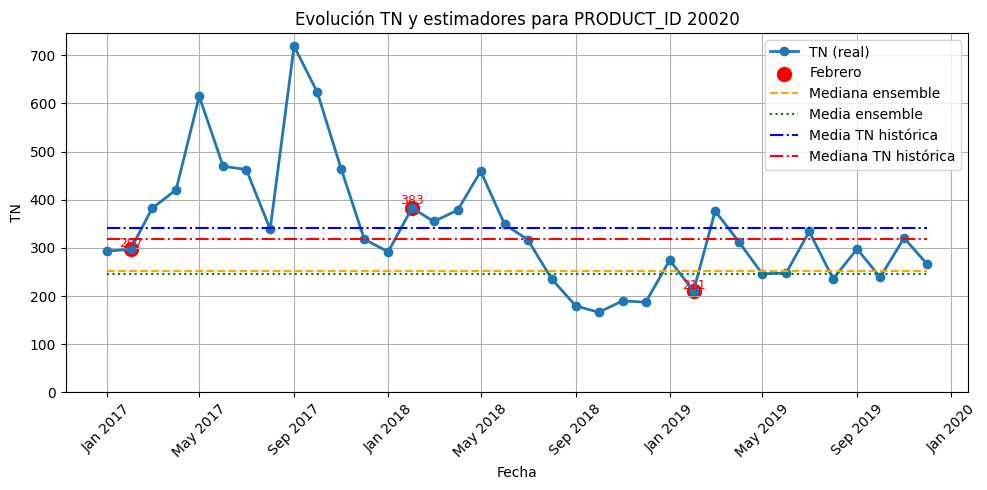

In [16]:

# Seleccionar los primeros 20 PRODUCT_ID únicos
productos = df_merged['PRODUCT_ID'].unique()[:20]

for pid in productos:
    data = df_merged[df_merged['PRODUCT_ID'] == pid].sort_values('FECHA')
    
    # Media y mediana históricas de TN para ese producto
    media_hist = data['TN'].mean()
    mediana_hist = data['TN'].median()

    # Separar puntos de febrero
    febrero = data[data['FECHA'].dt.month == 2]

    plt.figure(figsize=(10, 5))
    plt.plot(data['FECHA'], data['TN'], marker='o', label='TN (real)', linewidth=2)
    
    # Puntos de febrero destacados
    plt.scatter(febrero['FECHA'], febrero['TN'], color='red', s=100, label='Febrero')

    # Etiquetas sobre cada punto de febrero
    for _, row in febrero.iterrows():
        plt.text(row['FECHA'], row['TN'] + (row['TN'] * 0.02),  # etiqueta ligeramente encima
                 f"{row['TN']:.0f}", color='red', fontsize=9, ha='center')

    # Líneas horizontales
    plt.hlines(data['ensemble_median'].iloc[0], data['FECHA'].min(), data['FECHA'].max(),
               colors='orange', linestyles='--', label='Mediana ensemble')
    plt.hlines(data['ensemble_mean'].iloc[0], data['FECHA'].min(), data['FECHA'].max(),
               colors='green', linestyles=':', label='Media ensemble')
    plt.hlines(media_hist, data['FECHA'].min(), data['FECHA'].max(),
               colors='blue', linestyles='-.', label='Media TN histórica')
    plt.hlines(mediana_hist, data['FECHA'].min(), data['FECHA'].max(),
               colors='red', linestyles='-.', label='Mediana TN histórica')

    # Configuración del gráfico
    plt.title(f'Evolución TN y estimadores para PRODUCT_ID {pid}')
    plt.xlabel('Fecha')
    plt.ylabel('TN')
    plt.ylim(bottom=0)
    plt.grid(True)
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Ej: Jun 2025
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [ ]:
import pandas as pd
import numpy as np
from kaggle.api.kaggle_api_extended import KaggleApi

# 1. Cargar el DataFrame de predicciones (ajustá el nombre si es otro)
df = pd.read_csv("submission_ensemble_median.csv")  # Debe tener columnas product_id, tn

# 2. Configuración
COMPETITION = "labo-iii-edicion-2025-v"  # <---- Cambiá esto por el "ref" de tu competencia de Kaggle, ejemplo: 'copa-america-2025'
product_id_modificar = 20001
tn_original = df.loc[df["product_id"] == product_id_modificar, "tn"].values[0]

# 3. Rango de variaciones (porcentaje, ejemplo -10% a +10%)
porcentajes = np.linspace(-0.10, 0.10, 20)  # 20 valores entre -10% y +10%

# 4. Inicializar API
api = KaggleApi()
api.authenticate()

# 5. Generar, guardar y subir archivos
for i, pct in enumerate(porcentajes, 1):
    df_sub = df.copy()
    nuevo_valor = max(0, tn_original * (1 + pct))  # No puede ser menor a 0
    df_sub.loc[df_sub["product_id"] == product_id_modificar, "tn"] = nuevo_valor

    filename = f"submission_{i:02d}_pct_{int(pct*100):+d}.csv"
    df_sub.to_csv(filename, index=False, float_format="%.8f")

    print(f"Subiendo {filename}...")
    api.competition_submit(
        file_name=filename,
        message=f"Variación {pct:+.2%} en 20001",
        competition=COMPETITION
    )

print("Listo, se subieron los 20 archivos automáticamente.")



In [ ]:
import pandas as pd
import numpy as np
from kaggle.api.kaggle_api_extended import KaggleApi

# 1. Cargar el DataFrame de predicciones
df = pd.read_csv("submission_ensemble_median.csv")  # Asegurate que existe y tiene las columnas product_id, tn

# 2. Configuración
COMPETITION = "labo-iii-edicion-2025-v"  # Cambia esto si el ref es diferente
product_id_modificar = 20001
tn_original = df.loc[df["product_id"] == product_id_modificar, "tn"].values[0]

# 3. Rango de variaciones: de -10% a -40% (20 valores equidistantes)
porcentajes = np.linspace(-0.10, -0.40, 20)

# 4. Inicializar API
api = KaggleApi()
api.authenticate()

# 5. Generar, guardar y subir archivos
for i, pct in enumerate(porcentajes, 1):
    df_sub = df.copy()
    nuevo_valor = max(0, tn_original * (1 + pct))  # Nunca menor a 0
    df_sub.loc[df_sub["product_id"] == product_id_modificar, "tn"] = nuevo_valor

    filename = f"submission_{i:02d}_pct_{int(pct*100):+d}.csv"
    df_sub.to_csv(filename, index=False, float_format="%.8f")

    print(f"Subiendo {filename}...")
    api.competition_submit(
        file_name=filename,
        message=f"Variación {pct:+.2%} en 20001",
        competition=COMPETITION
    )

print("Listo, se subieron los 20 archivos automáticamente.")


In [ ]:
import pandas as pd
import numpy as np
from kaggle.api.kaggle_api_extended import KaggleApi

# 1. Cargar el DataFrame de predicciones
df = pd.read_csv("submission_ensemble_median.csv")  # Ajustá si el nombre es otro

# 2. Configuración
COMPETITION = "labo-iii-edicion-2025-v"  # Cambia esto si corresponde
product_id_modificar = 20001
tn_original = df.loc[df["product_id"] == product_id_modificar, "tn"].values[0]

# 3. Rango de variaciones entre -6.84% y -8.95% (negativos, 10 valores)
porcentajes = np.linspace(-0.0684, -0.0895, 10)

# 4. Inicializar API
api = KaggleApi()
api.authenticate()

# 5. Generar, guardar y subir archivos
for i, pct in enumerate(porcentajes, 1):
    df_sub = df.copy()
    nuevo_valor = max(0, tn_original * (1 + pct))
    df_sub.loc[df_sub["product_id"] == product_id_modificar, "tn"] = nuevo_valor

    pct_str = f"{pct*100:.2f}".replace('.', '_')
    filename = f"submission_sel_{i:02d}_pct_{pct_str}.csv"
    df_sub.to_csv(filename, index=False, float_format="%.8f")

    print(f"Subiendo {filename} (variación {pct:+.4%}) ...")
    api.competition_submit(
        file_name=filename,
        message=f"Variación {pct:+.4%} en 20001",
        competition=COMPETITION
    )

print("Listo, envíos realizados.")


In [ ]:
print(df.head(50))  # Mostrar las primeras 50 filas del DataFrame original

In [ ]:
import pandas as pd
import numpy as np
from kaggle.api.kaggle_api_extended import KaggleApi

def enviar_variaciones_kaggle(
    df_path,          # Ruta al archivo base CSV
    product_id,       # PRODUCT_ID a modificar
    valor_inf,        # Porcentaje inferior, ej: -0.3 para -30%
    valor_sup,        # Porcentaje superior, ej: 0.3 para +30%
    n_envios,         # Cantidad de envíos
    competition,      # ID de la competencia en Kaggle
    prefix="submission" # Prefijo para el archivo
):
    df = pd.read_csv(df_path)
    tn_original = df.loc[df["product_id"] == product_id, "tn"].values[0]
    
    # Rango de porcentajes, SIN incluir 0
    porcentajes = np.linspace(valor_inf, valor_sup, n_envios + 1)
    porcentajes = porcentajes[porcentajes != 0]
    
    # Inicializar API
    api = KaggleApi()
    api.authenticate()
    
    # Generar, guardar y subir archivos
    for i, pct in enumerate(porcentajes, 1):
        df_sub = df.copy()
        nuevo_valor = max(0, tn_original * (1 + pct))
        df_sub.loc[df_sub["product_id"] == product_id, "tn"] = nuevo_valor

        pct_str = f"{pct*100:+.2f}".replace('.', '_')
        filename = f"{prefix}_{product_id}_{i:02d}_pct_{pct_str}.csv"
        df_sub.to_csv(filename, index=False, float_format="%.8f")

        print(f"Subiendo {filename} (variación {pct:+.2%}) ...")
        api.competition_submit(
            file_name=filename,
            message=f"Variación {pct:+.2%} en {product_id}",
            competition=competition
        )
    print(f"Listo, {len(porcentajes)} envíos realizados para {product_id} entre {valor_inf:+.2%} y {valor_sup:+.2%}.")

# Ejemplo de uso:
enviar_variaciones_kaggle(
     df_path="submission_ensemble_median.csv",
     product_id=20033,
     valor_inf=-0.28,
     valor_sup=-0.12,
     n_envios=3,        # 6 valores (sin el cero)
     competition="labo-iii-edicion-2025-v"
)



In [ ]:
import pandas as pd

# IDs a consultar
productos = [20001,20006, 20007, 20032, 20012, 20018,20017,20043,20033]

# Cargar el archivo de Kaggle submission
df = pd.read_csv('submission_ensemble_median.csv')  # asegurate de tener este archivo en el mismo directorio

# Filtrar los productos de interés
df_seleccion = df[df['product_id'].isin(productos)]

print("Valores actuales en submission_ensemble_median.csv:")
print(df_seleccion)


In [22]:
display(df_rank)
# Generar un csv con PRODUCT_ID como product_id y lgbm_median como tn haciendo clip en 0 de lgbm_median
df_lgbm = df_rank[['PRODUCT_ID', 'lgbm_median']].rename(columns={'PRODUCT_ID': 'product_id', 'lgbm_median': 'tn'})
df_lgbm['tn'] = df_lgbm['tn'].clip(lower=0)
df_lgbm.to_csv('submission_lgbm_median.csv', index=False, float_format='%.8f')  



,PRODUCT_ID,mlp_median,lgbm_median,ensemble_median,mlp_mean,lgbm_mean,ensemble_mean,mlp_std,lgbm_std,ensemble_std,abs_diff_mlp_lgbm_median,mean_tn_historica,median_tn_historica,mlp_std_rank,ensemble_std_rank,abs_diff_median_rank,total_score
0,20001,2618.6396,918.6569,1084.8481,3084.7244,963.1231,2023.9242,2627.0340,115.3843,2135.1941,1699.9827,1398.3443,1418.0234,1.0000,1.0000,1.0000,1.0000
1,20004,362.2552,509.6626,486.8227,364.5149,506.1119,435.3135,140.8418,23.7860,123.1304,147.4074,671.6154,596.9093,5.0000,5.0000,3.0000,4.3333
2,20005,465.1850,549.5322,539.5082,488.5388,549.7769,519.1579,218.3652,22.4186,157.4694,84.3472,644.2005,578.5720,4.0000,4.0000,6.0000,4.6667
3,20003,756.6586,704.0600,706.4827,802.9189,704.8206,753.8697,388.0083,33.9816,278.4179,52.5986,889.0042,786.7157,3.0000,3.0000,10.0000,5.3333
4,20009,341.1888,502.2012,477.1828,338.3986,503.4904,420.9445,101.4315,18.9796,110.2414,161.0124,469.1951,465.0901,8.0000,6.0000,2.0000,5.3333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,21164,0.1970,0.2180,0.2114,0.2027,0.2138,0.2082,0.1157,0.0251,0.0835,0.0210,0.4308,0.3702,771.0000,774.0000,754.0000,766.3333
776,21209,0.0650,0.0632,0.0632,0.0899,0.0602,0.0751,0.1248,0.0195,0.0901,0.0018,0.1988,0.1195,760.0000,766.0000,776.0000,767.3333
777,21246,0.0050,0.0241,0.0219,0.0154,0.0248,0.0201,0.1134,0.0190,0.0810,0.0191,0.0900,0.0367,773.0000,776.0000,756.0000,768.3333
778,21244,-0.0051,0.0171,0.0157,0.0036,0.0157,0.0097,0.1099,0.0150,0.0782,0.0222,0.0928,0.0480,779.0000,780.0000,749.0000,769.3333


In [23]:
# Idem para la media de lgbm
df_lgbm_mean = df_rank[['PRODUCT_ID', 'lgbm_mean']].rename(columns={'PRODUCT_ID': 'product_id', 'lgbm_mean': 'tn'})
df_lgbm_mean['tn'] = df_lgbm_mean['tn'].clip(lower=0)
df_lgbm_mean.to_csv('submission_lgbm_mean.csv', index=False, float_format='%.8f')

In [28]:
import pandas as pd
import numpy as np
from kaggle.api.kaggle_api_extended import KaggleApi

def enviar_variaciones_todos_perturbados(
    df_path,
    valor_inf,
    valor_sup,
    n_envios,
    competition,
    prefix="submission_lgbm_median"
):
    df = pd.read_csv(df_path)
    
    # Rango de porcentajes, SIN incluir 0
    porcentajes = np.linspace(valor_inf, valor_sup, n_envios + 1)
    porcentajes = porcentajes[porcentajes != 0]
    
    api = KaggleApi()
    api.authenticate()
    
    for i, pct in enumerate(porcentajes, 1):
        df_sub = df.copy()
        df_sub["tn"] = (df_sub["tn"] * (1 + pct)).clip(lower=0)
        
        pct_str = f"{pct*100:+.2f}".replace('.', '_')
        filename = f"{prefix}_all_{i:02d}_pct_{pct_str}.csv"
        df_sub.to_csv(filename, index=False, float_format="%.8f")

        print(f"Subiendo {filename} (variación {pct:+.2%} en TODOS)...")
        api.competition_submit(
            file_name=filename,
            message=f"Perturbación {pct:+.2%} en TODOS (lgbm_median)",
            competition=competition
        )
    print(f"Listo, {len(porcentajes)} envíos realizados, todos los productos perturbados a la vez entre {valor_inf:+.2%} y {valor_sup:+.2%}.")

# Ejemplo de uso:
enviar_variaciones_todos_perturbados(
    df_path="submission_lgbm_median.csv",
    valor_inf=0.17,
    valor_sup=0.24,
    n_envios=4,  # 10 archivos, todos los productos pertubados al mismo % en cada archivo
    competition="labo-iii-edicion-2025-v"
)


Subiendo submission_lgbm_median_all_01_pct_+17_00.csv (variación +17.00% en TODOS)...


100%|██████████| 13.4k/13.4k [00:00<00:00, 28.0kB/s]


Subiendo submission_lgbm_median_all_02_pct_+18_75.csv (variación +18.75% en TODOS)...


100%|██████████| 13.4k/13.4k [00:00<00:00, 27.2kB/s]


Subiendo submission_lgbm_median_all_03_pct_+20_50.csv (variación +20.50% en TODOS)...


100%|██████████| 13.4k/13.4k [00:00<00:00, 24.9kB/s]


Subiendo submission_lgbm_median_all_04_pct_+22_25.csv (variación +22.25% en TODOS)...


100%|██████████| 13.4k/13.4k [00:00<00:00, 27.8kB/s]


Subiendo submission_lgbm_median_all_05_pct_+24_00.csv (variación +24.00% en TODOS)...


100%|██████████| 13.4k/13.4k [00:00<00:00, 24.6kB/s]


Listo, 5 envíos realizados, todos los productos perturbados a la vez entre +17.00% y +24.00%.


In [2]:
import pandas as pd
import numpy as np
from kaggle.api.kaggle_api_extended import KaggleApi

def enviar_variaciones_todos_perturbados(
    df_path,
    valor_inf,
    valor_sup,
    n_envios,
    competition,
    prefix="submission_lgbm_mean"  # Cambiado para media
):
    df = pd.read_csv(df_path)
    
    # Rango de porcentajes, SIN incluir 0
    porcentajes = np.linspace(valor_inf, valor_sup, n_envios + 1)
    porcentajes = porcentajes[porcentajes != 0]
    
    api = KaggleApi()
    api.authenticate()
    
    for i, pct in enumerate(porcentajes, 1):
        df_sub = df.copy()
        df_sub["tn"] = (df_sub["tn"] * (1 + pct)).clip(lower=0)
        
        pct_str = f"{pct*100:+.2f}".replace('.', '_')
        filename = f"{prefix}_all_{i:02d}_pct_{pct_str}.csv"
        df_sub.to_csv(filename, index=False, float_format="%.8f")

        print(f"Subiendo {filename} (variación {pct:+.2%} en TODOS)...")
        api.competition_submit(
            file_name=filename,
            message=f"Perturbación {pct:+.2%} en TODOS (lgbm_mean)",
            competition=competition
        )
    print(f"Listo, {len(porcentajes)} envíos realizados, todos los productos perturbados a la vez entre {valor_inf:+.2%} y {valor_sup:+.2%}.")

# Ejemplo de uso:
enviar_variaciones_todos_perturbados(
    df_path="lgbm_predictions.csv",  # Archivo con media
    valor_inf=0.115,
    valor_sup=0.145,
    n_envios=5,  # 20 archivos, todos los productos perturbados al mismo % en cada archivo
    competition="labo-iii-edicion-2025-v"
)


Subiendo submission_lgbm_mean_all_01_pct_+11_50.csv (variación +11.50% en TODOS)...


100%|██████████| 13.4k/13.4k [00:00<00:00, 26.0kB/s]


Subiendo submission_lgbm_mean_all_02_pct_+12_10.csv (variación +12.10% en TODOS)...


100%|██████████| 13.4k/13.4k [00:00<00:00, 25.3kB/s]


Subiendo submission_lgbm_mean_all_03_pct_+12_70.csv (variación +12.70% en TODOS)...


100%|██████████| 13.4k/13.4k [00:00<00:00, 26.5kB/s]


Subiendo submission_lgbm_mean_all_04_pct_+13_30.csv (variación +13.30% en TODOS)...


100%|██████████| 13.4k/13.4k [00:00<00:00, 26.9kB/s]


Subiendo submission_lgbm_mean_all_05_pct_+13_90.csv (variación +13.90% en TODOS)...


100%|██████████| 13.4k/13.4k [00:00<00:00, 27.1kB/s]


Subiendo submission_lgbm_mean_all_06_pct_+14_50.csv (variación +14.50% en TODOS)...


100%|██████████| 13.4k/13.4k [00:00<00:00, 25.4kB/s]


Listo, 6 envíos realizados, todos los productos perturbados a la vez entre +11.50% y +14.50%.
